# Test on common processes

Test of common processes, such as `count`, `scan`, and `grid_scan`.

## Prepare

- Import necessary modules
- Prepare data group
- Prepare scheduler
- Prepare parameters

In [1]:
from pprint import pprint
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import softlab as sl
from softlab.jin.validator import ValNumber
from softlab.tu.station import Parameter
from softlab.shui.data import DataGroup
from softlab.huo.process import (
    run_process,
    count,
    scan,
    grid_scan,
)

import nest_asyncio
nest_asyncio.apply()

print(f'Import numpy V{np.__version__}')
print(f'Import pandas V{pd.__version__}')
print(f'Import softlab V{sl.__version__}')

Import numpy V1.26.2
Import pandas V2.1.3
Import softlab V0.2.1


In [2]:
group = DataGroup('test_common_proc')

In [3]:
sch = sl.huo.scheduler.get_scheduler()
sch.start()

True

In [4]:
t0 = datetime.now().timestamp()

In [5]:
theta = 10.0

In [6]:
freq = Parameter('freq', ValNumber(1e-3), init_value=50.0)
power = Parameter('power', ValNumber(), init_value=0.0)
print('Prepare parameters to set')
pprint(freq.snapshot())
pprint(power.snapshot())

Prepare parameters to set
{'gettable': True,
 'name': 'freq',
 'owner': 'None',
 'settable': True,
 'type': <class 'softlab.tu.station.parameter.Parameter'>,
 'validator': "Validator for (<class 'int'>, <class 'float'>, <class "
              "'numpy.integer'>, <class 'numpy.floating'>) (0.001 ~ inf)"}
{'gettable': True,
 'name': 'power',
 'owner': 'None',
 'settable': True,
 'type': <class 'softlab.tu.station.parameter.Parameter'>,
 'validator': "Validator for (<class 'int'>, <class 'float'>, <class "
              "'numpy.integer'>, <class 'numpy.floating'>) (-inf ~ inf)"}


In [7]:
def sine(*_) -> float:
    return np.sin(np.pi * 2.0 * freq() * (datetime.now().timestamp() - t0))

def win(*_) -> float:
    f = np.exp(-theta * power())
    return (1.0 - f) / (1.0 + f)

In [8]:
sig = Parameter('input', ValNumber(), settable=False, before_get=sine)
print(f'Prepare input signal {sig()}')

Prepare input signal -0.520369504693338


In [9]:
window = Parameter('window', ValNumber(), settable=False, before_get=win)
print(f'Prepare window {window()}')

Prepare window 0.0


In [10]:
output = Parameter('output', ValNumber(), settable=False, before_get=lambda _: sig() * window())
print(f'Prepare output {output()}')

Prepare output -0.0


In [11]:
times = 100
timestamps = np.linspace(0.0, 1.0, times, False)

In [12]:
frequencies = list(map(lambda t: 10.0 if t < 0.5 else 6.0, timestamps))

def triangle(t):
    return 4.0 * (t - round(t / 0.5) * 0.5) * (1.0 - 2.0 * (round(t / 0.5) % 2))

powers = list(map(triangle, timestamps))

## Test on count

In [13]:
def set_freq():
    t = datetime.now().timestamp() - t0
    freq(10.0 if t < 0.5 else 6.0)

counter = count('input', group, None, freq, sig,
                times=times, delay_gap=1.0/times, hook_before_get=set_freq)

In [14]:
t0 = datetime.now().timestamp()

counter.t0(t0)
run_process(counter, sch)

---- Run Process ----
Reset process first
class: <class 'softlab.huo.process.common.Counter'>
name: input
pending: False
more: True



C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


Succeed
Commit 102 Times
Used 1.5822566999999998 s
---- The End ----



(True, 1.5822566999999998)

C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


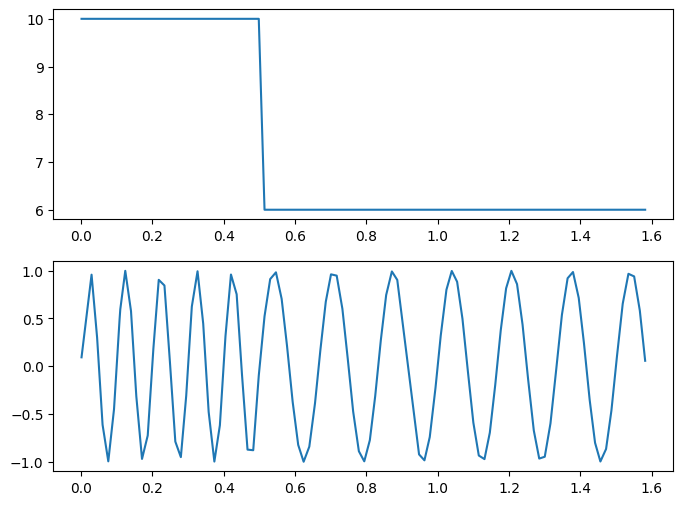

In [15]:
df_freq = group.record('input').table
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.plot(df_freq.timestamp, df_freq.freq)
plt.subplot(212)
plt.plot(df_freq.timestamp, df_freq.input)
plt.show()

## Test on scan

In [16]:
scanner = scan('scan', [sig, window, output], group, None,
               freq, frequencies, power, powers,
               delay_gap=1.0/times)

In [17]:
t0 = datetime.now().timestamp()

scanner.t0(t0)
run_process(scanner, sch)

---- Run Process ----
Reset process first
class: <class 'softlab.huo.process.common.Scanner'>
name: scan
pending: False
more: True



C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


Succeed
Commit 102 Times
Used 1.5650594 s
---- The End ----



(True, 1.5650594)

C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


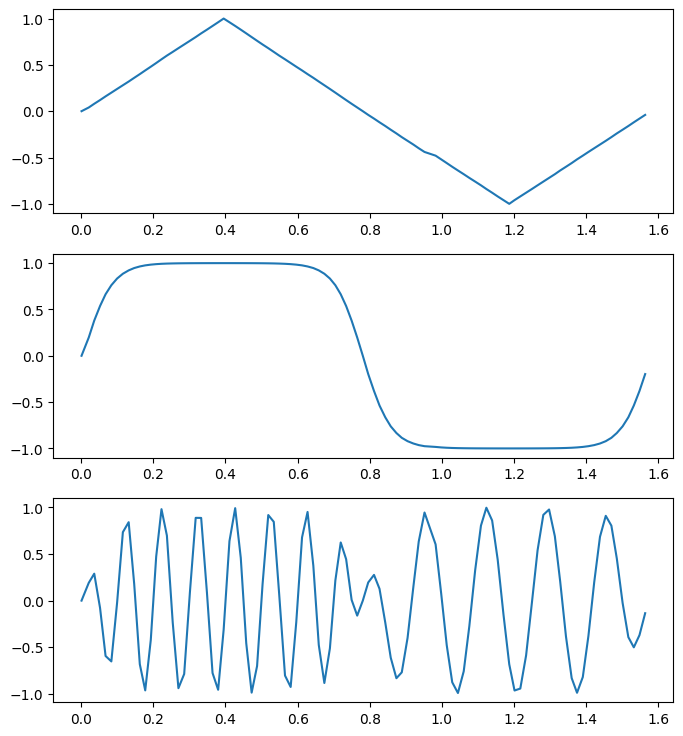

In [18]:
df_scan = group.record('scan').table
plt.figure(figsize=(8, 9))
plt.subplot(311)
plt.plot(df_scan.timestamp, df_scan.power)
plt.subplot(312)
plt.plot(df_scan.timestamp, df_scan.window)
plt.subplot(313)
plt.plot(df_scan.timestamp, df_scan.output)
plt.show()

## Test on grid scan

In [19]:
print('Prepare parameters to grid scan')

seed = Parameter('seed', ValNumber())
seed_values = np.linspace(-1.0, 1.0, 101, True)

packet = Parameter('packet', ValNumber())
packet_values = np.linspace(-100.0, 100.0, 21, True)

Prepare parameters to grid scan


In [20]:
res_freq = 3.0
res_sigma = 30.0

response = Parameter(
    'response', ValNumber(), settable=False,
    before_get=lambda _: np.sin(2.0 * np.pi * res_freq * seed()) * \
        np.exp(-packet() * packet() / 2.0 / res_sigma / res_sigma))

In [21]:
gs = grid_scan('grid_scan', [response], group, None,
               seed, seed_values.tolist(), packet, packet_values.tolist())

In [22]:
t0 = datetime.now().timestamp()

gs.t0(t0)
run_process(gs, sch)

---- Run Process ----
Reset process first
class: <class 'softlab.huo.process.common.GridScanner'>
name: grid_scan
pending: False
more: True



C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


Succeed
Commit 2123 Times
Used 2.6345134000000003 s
---- The End ----



(True, 2.6345134000000003)

C:\Workspace\drp\softlab\softlab\shui\data\base.py:311: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._table = pd.concat([self._table, new_rows], ignore_index=True)\


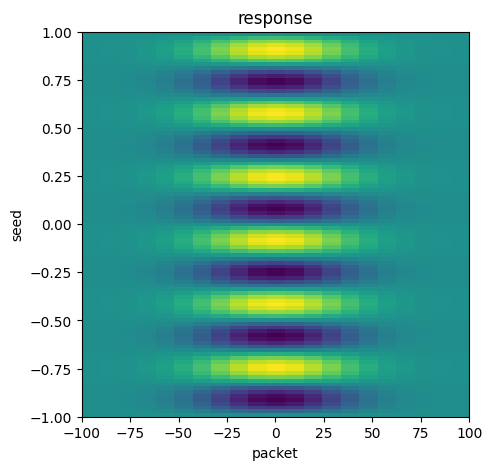

In [23]:
df_grid = group.record('grid_scan').table
plt.figure(figsize=(5, 5))
plt.imshow(df_grid.response.to_numpy().reshape(
    (len(packet_values), len(seed_values))).T,
    aspect='auto',
    extent=(packet_values[0], packet_values[-1], seed_values[0], seed_values[-1]))
plt.xlabel('packet')
plt.ylabel('seed')
plt.title('response')
plt.show()